In [ ]:
!pip install -q transformers[torch] datasets jiwer accelerator

### Read Dataset

In [1]:
import os

import pandas as pd

In [2]:
data_path = "data/flickr30k/"  # PROVIDE THE RIGHT PATH TO IMAGE DATA FOLDER
csv_file = "dataset.csv"
images_path = os.path.join(data_path, "images")
encoder_path = "google/vit-base-patch16-224-in21k"
# decoder_path = "HooshvareLab/gpt2-fa"
# decoder_path = "flax-community/gpt2-medium-persian"

# encoder_path = "microsoft/beit-base-patch16-224"
decoder_path = "HooshvareLab/roberta-fa-zwnj-base"


#### Generate image/text pairs dataframe

In [3]:
df = pd.read_csv(os.path.join(data_path, csv_file))
df = df.dropna()
df.head()

,caption,image
0,دو مرد با پیراهن سبز در حیاط ایستاده اند.,1000092795.jpg
1,سه مرد روی یک دکل بزرگ.,10002456.jpg
2,دختر بچه ای در حال بالا رفتن از یک خانه بازی چوبی,1000268201.jpg
3,مردی روی نردبان پنجره ای را تمیز می کند,1000344755.jpg
4,دو مرد در حال پختن غذا هستند.,1000366164.jpg


We split up the data into training + testing, using sklearn's `train_test_split` function.

#### Train/Test split

In [4]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

### Dataset Class

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Flickr30kFa(Dataset):
    def __init__(self, root_dir, df, image_processor, tokenizer, max_target_length=128, return_text=True):
        self.root_dir = root_dir
        self.df = df
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length
        self.return_text = return_text
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        file_name = self.df["image"][index]
        caption = self.df["caption"][index]

        image_path = os.path.join(self.root_dir, file_name)
        image = Image.open(image_path).convert("RGB")

        pixel_values = self.image_processor(image, return_tensors="pt").pixel_values
        # caption = f"{tokenizer.eos_token}{caption}{tokenizer.eos_token}"
        tokenized_outputs = self.tokenizer(
            caption,
            add_special_tokens=True,
            padding="max_length", 
            max_length=self.max_target_length, 
            truncation=True,
        )
        

        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(tokenized_outputs["input_ids"]),
            "attention_mask": tokenized_outputs["attention_mask"],
        }
        if self.return_text:
            encoding["text"] = caption

        return encoding


/home/aryan/Applications/miniconda3/envs/main/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's initialize the training and evaluation datasets:

In [6]:
from transformers import ViTImageProcessor, AutoTokenizer

image_processor = ViTImageProcessor.from_pretrained(encoder_path, size=224)
tokenizer = AutoTokenizer.from_pretrained(decoder_path)
tokenizer.add_special_tokens({"pad_token": "<pad>", "sep_token": "<sep>", "cls_token": "<cls>"})
tokenizer.pad_token = tokenizer.eos_token
train_dataset = Flickr30kFa(root_dir=images_path, df=train_df, image_processor=image_processor, tokenizer=tokenizer)
eval_dataset = Flickr30kFa(root_dir=images_path, df=eval_df, image_processor=image_processor, tokenizer=tokenizer)

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 25905
Number of validation examples: 6477


Let's verify an example from the training dataset:

In [9]:
image, labels, _, texts = list(train_dataset[0].values())
print(image.shape, labels.shape)

torch.Size([3, 224, 224]) torch.Size([128])


We can also check the original image and decode the labels:

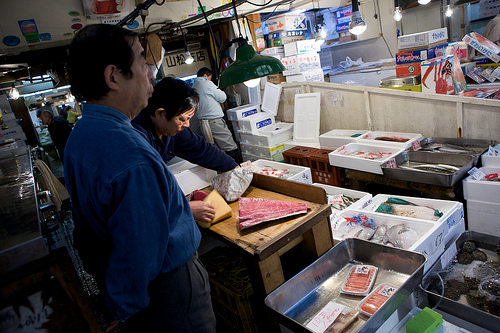

In [10]:
image = Image.open(os.path.join(train_dataset.root_dir, train_df['image'][0])).convert("RGB")
image

In [11]:
label_str = tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

مردی با پیراهن جین آبی مشغول تماشای کار در یک کارخانه ماهی است.


## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [12]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_path, decoder_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of RobertaForCausalLM were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['roberta.encoder.layer.9.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.self.query.bias', 'roberta.encoder.layer.2.crossattention.self.query.weight', 'roberta.encoder.layer.9.crossattention.self.key.bias', 'roberta.encoder.layer.5.crossattention.self.value.bias', 'roberta.encoder.layer.10.crossattention.self.key.weight', 'roberta.encoder.layer.2.crossattention.self.value.bias', 'roberta.encoder.layer.8.crossattention.self.key.weight', 'roberta.encoder.layer.3.crossattention.output.dense.weight', 'roberta.encoder.layer.6.crossattention.self.value.bias', 'roberta.encoder.layer.3.crossattention.self.query.weight', 'roberta.encoder.layer.5.crossattention.self.query.weight', 'roberta.encoder.layer.7.crossattention.output.dense.weight', 'roberta.encoder.layer.10.crossattention.output.LayerNorm.bias', 'roberta.encode

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [13]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.eos_token_id
model.config.max_length = 32
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [18]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    num_train_epochs=8,
    fp16=True,
    report_to="none",
    output_dir="./checkpoints",
    logging_steps=100,
)

In [19]:
import evaluate

metric = evaluate.load("wer")

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [20]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    
    wer = metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

In [25]:
final_model_path = "vit-roberta-image-captioning-flickr30k-fa-v1"
tokenizer.save_pretrained(final_model_path)
image_processor.save_pretrained(final_model_path)
trainer.model.save_pretrained(final_model_path)

# Inference

In [27]:
from transformers import ViTImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image

model_path = "vit-roberta-image-captioning-flickr30k-fa-v1"
sample = "image_captioning_example.jpg"
image = Image.open(sample).convert("RGB")

model = VisionEncoderDecoderModel.from_pretrained(model_path)
image_processor = ViTImageProcessor.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

pixel_values = image_processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(text)

سگی با توپ تنیس در دهانش می دود.


# Push to Hub

In [ ]:
from huggingface_hub import login
login()

In [ ]:
hub_repo = "hezarai/vit-roberta-image-captioning-flickr30k-fa"

model.push_to_hub(model_path)
image_processor.push_to_hub(model_path)
tokenizer.push_to_hub(model_path)

*_:)_*